In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [6]:
import csv

pcap_dfs = {}
with open(r'data\pluto\old-bidirectional\logs.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader, None)
    for file_base, label in reader:
        pcap_dfs[file_base] = pd.read_csv(f"data\\pluto\\old-bidirectional\\{file_base}.csv")

In [7]:
for pcap_df in list(pcap_dfs.values()):
    pcap_df['iat'] = pcap_df['timestamp'].diff()
    pcap_df.at[pcap_df.index[0], 'iat'] = 0

In [8]:
# Verify the data
for pcap_df_key in pcap_dfs.keys():
    pcap_df = pcap_dfs[pcap_df_key]
    start = pcap_df['timestamp'].min()
    end = pcap_df['timestamp'].max()
    total = end - start
    iat_sum = pcap_df['iat'].sum()
    print(pcap_df_key + " - total: " + str(total) + " iat_sum: " + str(iat_sum))

whatsapp2 - total: 80.40803790092468 iat_sum: 80.40803790092468
whatsapp3 - total: 37.13440489768982 iat_sum: 37.13440489768982
WhatsAppVideo-log1 - total: 378.04780888557434 iat_sum: 378.04780888557434
WhatsAppVideo-log2 - total: 507.0548520088196 iat_sum: 507.0548520088196
Webex-log1 - total: 425.9884388446808 iat_sum: 425.9884388446808
Webex-log2 - total: 464.19184017181396 iat_sum: 464.19184017181396
youtube1 - total: 108.32501316070557 iat_sum: 108.32501316070557
youtube2 - total: 136.56084299087524 iat_sum: 136.56084299087524
teams-audio1 - total: 201.21881008148193 iat_sum: 201.21881008148193
teams-audio2 - total: 128.299546957016 iat_sum: 128.299546957016
teams-video1 - total: 178.70912909507751 iat_sum: 178.70912909507751
teams-video2 - total: 192.01875710487366 iat_sum: 192.01875710487366


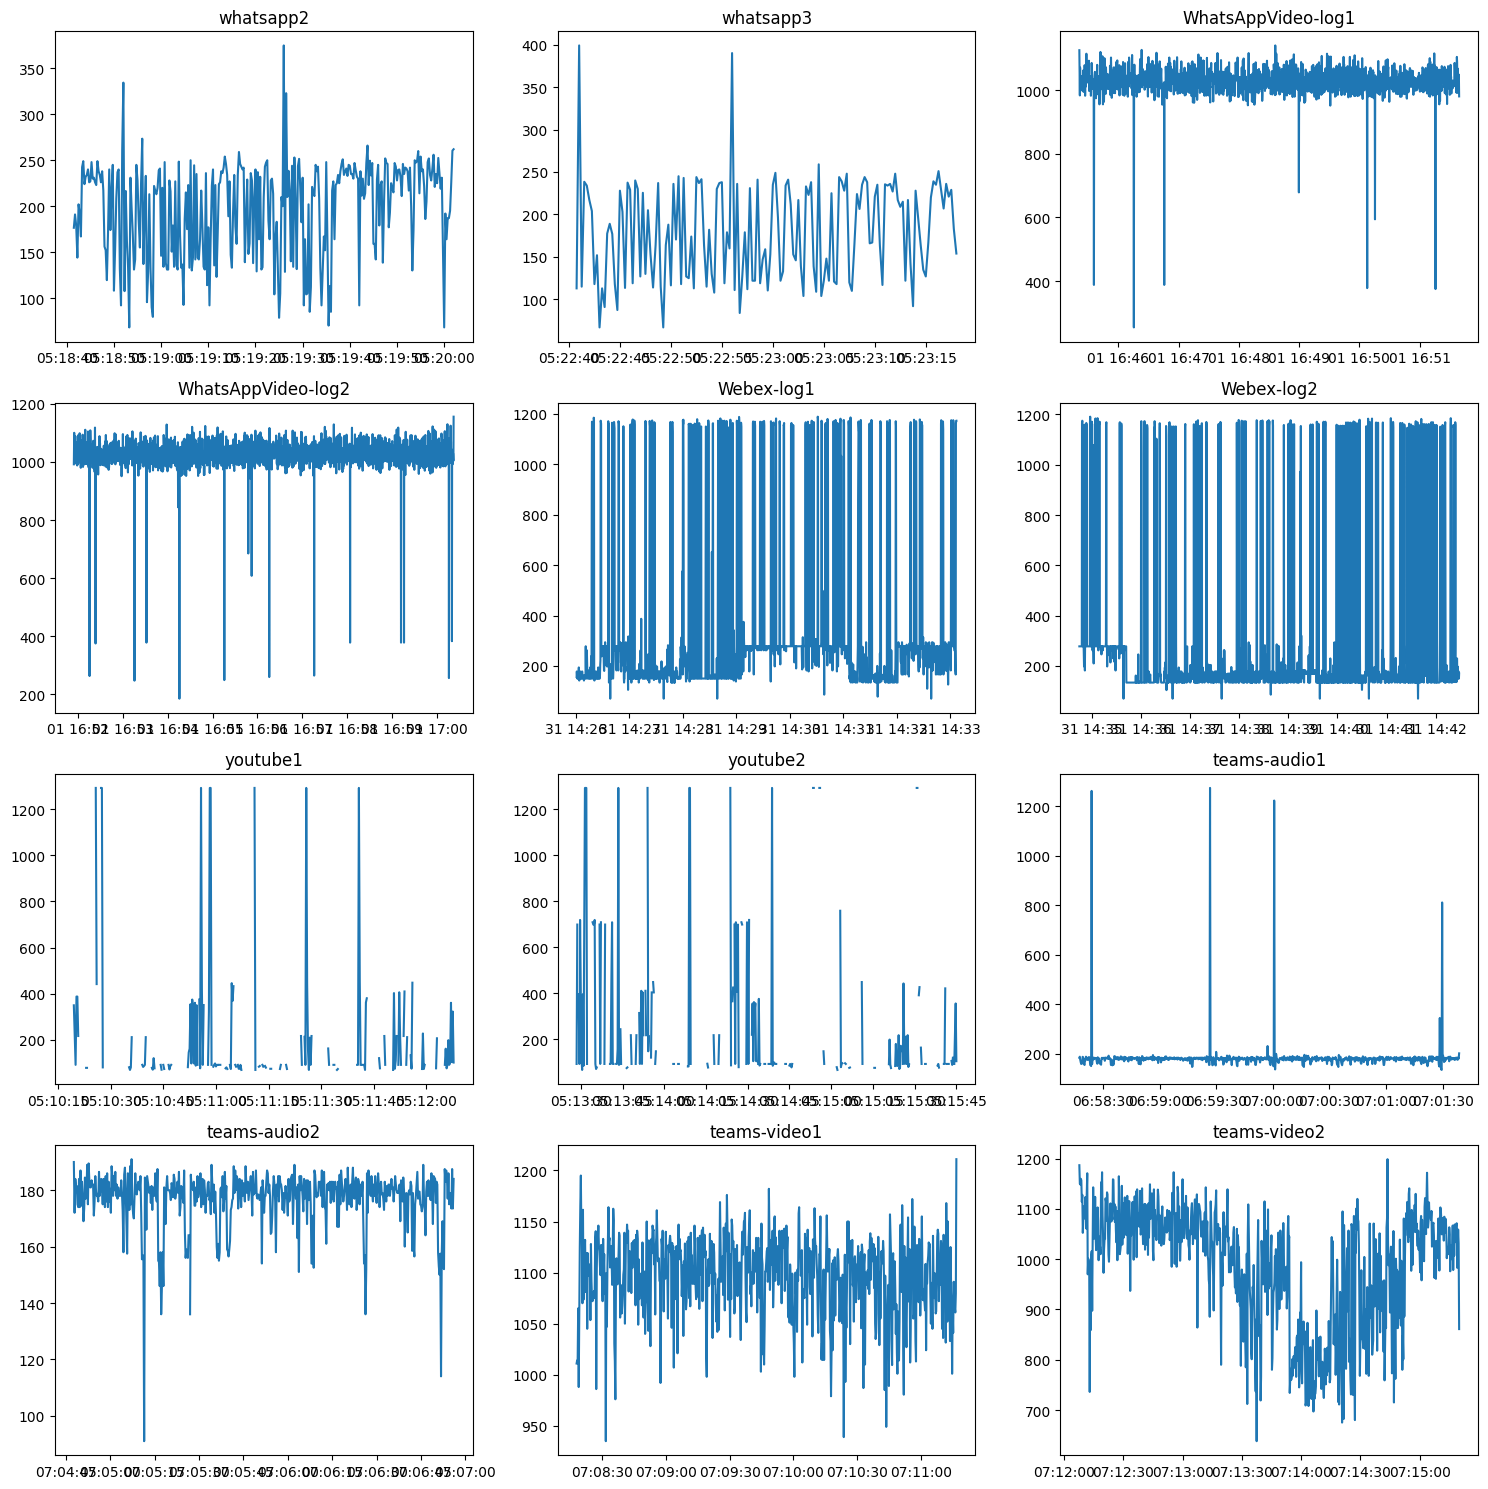

In [9]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15))

for i, pcap_df_key in enumerate(pcap_dfs.keys()):
    pcap_df_test = pcap_dfs[pcap_df_key]
    filtered_cols = pcap_df_test.drop(columns=['five-tuple', 'iat'])
    filtered_cols['timestamp'] = pd.to_datetime(filtered_cols['timestamp'], unit='s')
    filtered_cols = filtered_cols.set_index('timestamp').resample('250L').median()

    row, col = divmod(i, 3)  # Calculate the row and column index
    axs[row, col].plot(filtered_cols.index, filtered_cols['packet_size'])
    axs[row, col].set_title(pcap_df_key)

plt.tight_layout()
plt.show()

# CDF of PacketSize and IAT

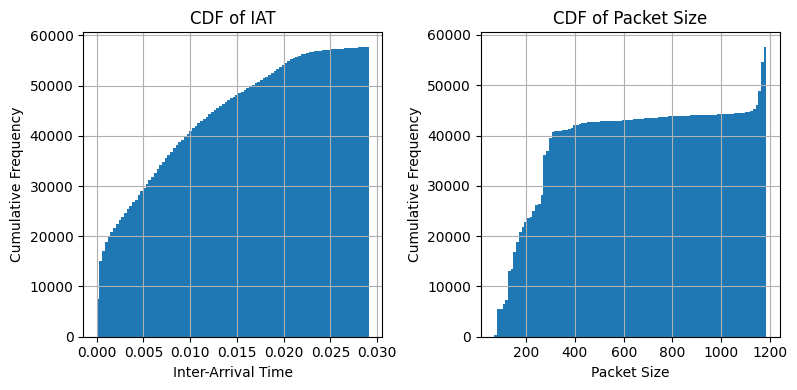

In [10]:
test_flow = pcap_dfs['Webex-log1']
outlier_cap = test_flow['iat'].quantile(.99)
filtered_iat = test_flow[test_flow['iat'] < outlier_cap]['iat']
outlier_cap = test_flow['packet_size'].quantile(.99)
test_ps = test_flow[test_flow['packet_size'] < outlier_cap]['packet_size']
fig, axs = plt.subplots(1,2, figsize=(8, 4))
filtered_iat.hist(bins=100, ax=axs[0], cumulative=1)
test_ps.hist(bins=100, ax=axs[1], cumulative=1)
axs[0].set_title('CDF of IAT')
axs[0].set_xlabel('Inter-Arrival Time')
axs[0].set_ylabel('Cumulative Frequency')
axs[1].set_title('CDF of Packet Size')
axs[1].set_xlabel('Packet Size')
axs[1].set_ylabel('Cumulative Frequency')
plt.tight_layout()
plt.show()

# Extracting the features

In [11]:
def create_features(flow_df):
    def custom_analysis(chunk):
        first_50 = chunk[chunk.index.microsecond < 50000]
        result = {
            'num_packets': len(chunk),
            'agg_size': chunk['packet_size'].sum(),
            'max_size': chunk['packet_size'].max(),
            'med_size': chunk['packet_size'].median(),
            'mean_size': chunk['packet_size'].mean(),
            'min_iat' : chunk['iat'].min(),
            'mean_iat': chunk['iat'].mean(),
            'med_iat': chunk['iat'].median(),
    
            'f50_num_packets': len(first_50),
            'f50_agg_size': first_50['packet_size'].sum(),
            'f50_max_size': first_50['packet_size'].max(),
            'f50_med_size': first_50['packet_size'].median(),
            'f50_mean_size': first_50['packet_size'].mean(),
            'f50_min_iat': first_50['iat'].min(),
            'f50_mean_iat': first_50['iat'].mean(),
            'f50_med_iat': first_50['iat'].median()
        }
        #raise Error("hi")
        return pd.Series(result)
        
    flow_df['timestamp'] = pd.to_datetime(flow_df['timestamp'], unit='s')
    flow_features = flow_df.set_index('timestamp').resample('1s').apply(custom_analysis).fillna(0)
    return flow_features

In [12]:
feature_dfs = []
for pcap_df_key in pcap_dfs.keys():
    feature_df = create_features(pcap_dfs[pcap_df_key])
    feature_df['label'] = pcap_df_key
    feature_dfs.append(feature_df)

In [13]:
combined_df = pd.concat(feature_dfs)

In [14]:
combined_df[combined_df['label'] == 'teams-audio2']

,num_packets,agg_size,max_size,med_size,mean_size,min_iat,mean_iat,med_iat,f50_num_packets,f50_agg_size,f50_max_size,f50_med_size,f50_mean_size,f50_min_iat,f50_mean_iat,f50_med_iat,label
timestamp,,,,,,,,,,,,,,,,,
2023-12-23 07:04:47,13.0,2449.0,210.0,190.0,188.384615,0.000000,0.017037,0.020027,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,teams-audio2
2023-12-23 07:04:48,70.0,18501.0,1274.0,182.0,264.300000,0.000015,0.014294,0.018876,5.0,834.0,183.0,166.0,166.800000,0.000075,0.011727,0.012645,teams-audio2
2023-12-23 07:04:49,59.0,10269.0,202.0,178.0,174.050847,0.000099,0.016950,0.019681,3.0,520.0,185.0,171.0,173.333333,0.019008,0.019977,0.020291,teams-audio2
2023-12-23 07:04:50,58.0,10176.0,204.0,178.0,175.448276,0.000000,0.017231,0.019691,5.0,758.0,178.0,175.0,151.600000,0.001349,0.011873,0.014811,teams-audio2
2023-12-23 07:04:51,73.0,18812.0,1274.0,176.0,257.698630,0.000034,0.013706,0.019188,3.0,499.0,174.0,163.0,166.333333,0.019238,0.019981,0.020143,teams-audio2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-23 07:06:52,45.0,6937.0,187.0,156.0,154.155556,0.000219,0.026387,0.019766,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,teams-audio2
2023-12-23 07:06:53,60.0,13906.0,1262.0,185.0,231.766667,0.000114,0.017032,0.019445,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,teams-audio2
2023-12-23 07:06:54,65.0,14768.0,1274.0,179.0,227.200000,0.000035,0.015370,0.019263,4.0,700.0,186.0,178.0,175.000000,0.006981,0.014656,0.015550,teams-audio2


In [15]:
from sklearn.decomposition import PCA

X = combined_df.drop(columns=['label'])
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [16]:
print(pca.explained_variance_ratio_)
transformed = pca.transform(X)
pca_df = pd.DataFrame(data=transformed, columns=['PC1', 'PC2'])
combined_df = combined_df.reset_index()

[0.99777389 0.00221327]


In [17]:
pca_df['label'] = combined_df['label']

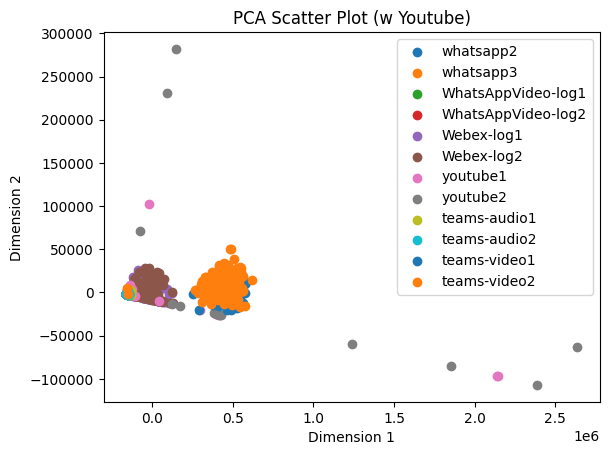

In [22]:
for pcap_df_key in pcap_dfs.keys():
    if "youdtube" in pcap_df_key:
        continue
    pca_df_cat = pca_df[pca_df['label'] == pcap_df_key]
    plt.scatter(pca_df_cat['PC1'], pca_df_cat['PC2'], label=pcap_df_key)
plt.title('PCA Scatter Plot (w Youtube)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(loc="upper right")

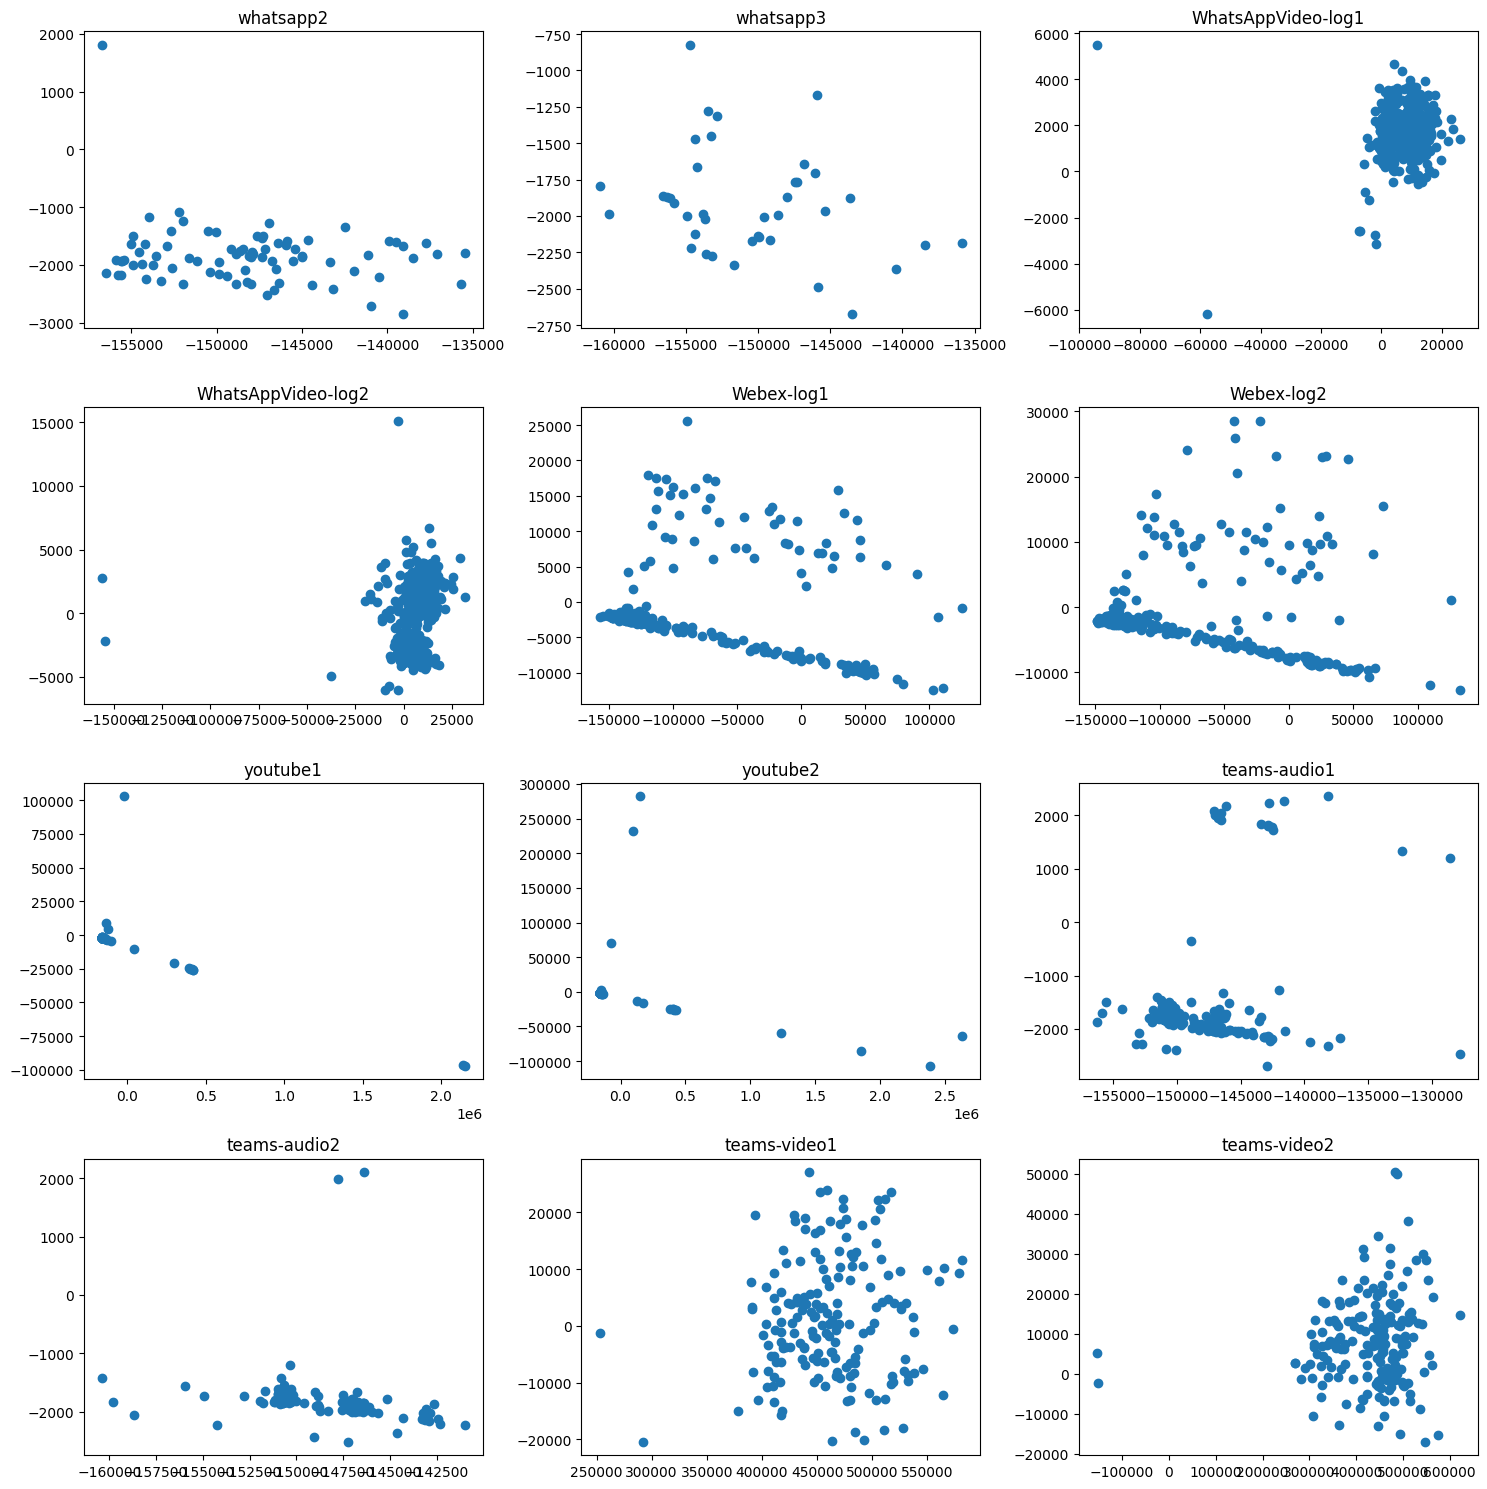

In [19]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15))

for i, pcap_df_key in enumerate(pcap_dfs.keys()):
    pca_df_cat = pca_df[pca_df['label'] == pcap_df_key]
    
    row, col = divmod(i, 3)  # Calculate the row and column index
    axs[row, col].scatter(pca_df_cat['PC1'], pca_df_cat['PC2'], label=pcap_df_key)
    axs[row, col].set_title(pcap_df_key)

plt.tight_layout()
plt.show()

# Random Forest Classifier

In [197]:
label_map = {'whatsapp2': 1, 'whatsapp3': 1, 'WhatsAppVideo-log1': 2, 'WhatsAppVideo-log2': 2, 'Webex-log1': 3, 'Webex-log2': 3, 'youtube1': 4, 'youtube2': 4, 'teams-audio1': 5, 'teams-audio2': 5, 'teams-video1': 6, 'teams-video2': 6}

In [200]:
from sklearn.model_selection import train_test_split

X = combined_df.drop(columns=['label', 'timestamp'])
Y = combined_df['label'].map(label_map)

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [202]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [203]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf_clf = RandomForestClassifier(max_depth=7, random_state=0, criterion='entropy',n_estimators=100)

In [204]:
rf_clf.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', max_depth=7, random_state=0)

In [205]:
y_train_pred = rf_clf.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_train_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


In [206]:
X_test_scaled = scaler.transform(X_test)
y_test_pred = rf_clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.99


In [207]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_test_pred)

In [208]:
conf_matrix

array([[ 21,   0,   0,   0,   0,   0],
       [  0, 184,   0,   0,   0,   0],
       [  0,   0, 176,   1,   0,   0],
       [  0,   0,   0,  44,   0,   0],
       [  0,   0,   1,   1,  68,   0],
       [  0,   0,   0,   0,   0,  75]], dtype=int64)

# Testing Mirage on this model

In [258]:
teams_test_df = pd.read_csv(r"data\teams_data\100.csv")
def seperate_flows(pcap_df):
    return dict(tuple(pcap_df.groupby('five-tuple')))

In [259]:
flows = seperate_flows(teams_test_df)
print("total flows: ", len(flows))
flow_stats = []
for flow_key in flows.keys():
    flow = flows[flow_key]
    length = flow.shape[0]
    start = flow.timestamp.min()
    end = flow.timestamp.max()
    total_time = end - start
    iat_sum = flow['iat'].sum()
    md_pkt_sz = flow['packet_size'].median()
    flow_stats.append([flow_key, length, start, end, total_time, iat_sum, md_pkt_sz])

flow_stats_df = pd.DataFrame(flow_stats, columns=['five-tuple', 'size', 'start', 'end', 'total_time', 'iat_sum', 'md_pkt_sz'])

total flows:  76


In [263]:
flow_stats_df[flow_stats_df['size'] > flow_stats_df['size'].quantile(.9)]

,five-tuple,size,start,end,total_time,iat_sum,md_pkt_sz
0,"192.168.20.103,34758,52.113.199.100,443,6",103,1.637257e+09,1.637258e+09,693.295319,693.295319,82.0
8,"192.168.20.103,44220,52.114.92.111,443,6",90,1.637257e+09,1.637258e+09,688.538752,688.538752,85.0
10,"192.168.20.103,46369,52.114.76.111,3478,17",164,1.637257e+09,1.637258e+09,683.640153,683.640153,65.0
38,"192.168.20.103,50014,87.9.197.203,50012,17",66460,1.637257e+09,1.637258e+09,680.782058,680.782058,153.0
45,"192.168.20.103,50024,87.9.197.203,50030,17",140895,1.637257e+09,1.637258e+09,680.977321,680.977321,1011.0
55,"192.168.20.103,50054,87.9.197.203,50055,17",1740,1.637257e+09,1.637258e+09,671.627328,671.627328,120.0
62,"192.168.20.103,53312,52.114.76.111,443,6",128,1.637257e+09,1.637258e+09,683.444316,683.444316,739.0
67,"192.168.20.103,56190,52.113.195.132,443,6",183,1.637257e+09,1.637257e+09,78.214958,78.214958,961.0


In [266]:
teams_test_flow_df = flows["192.168.20.103,50024,87.9.197.203,50030,17"]

In [269]:
teams_sorted_df = teams_test_flow_df.sort_values(by='timestamp').drop(columns=['five-tuple'])
teams_sorted_df['timestamp'] = pd.to_datetime(teams_sorted_df['timestamp'], unit='s')

In [270]:
teams_resampled_df = teams_sorted_df.set_index('timestamp').resample('250L').median().fillna(0)

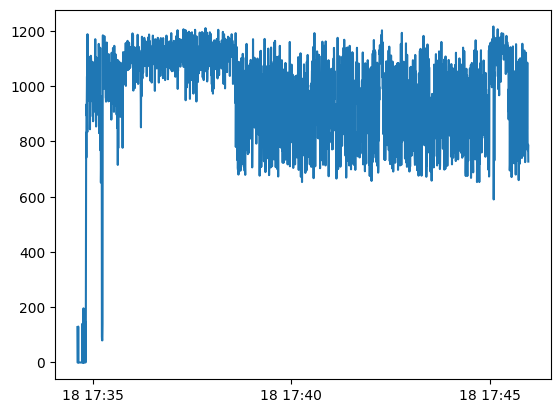

In [271]:
plt.plot(teams_resampled_df.index, teams_resampled_df['packet_size'])

In [272]:
teams_test_features = create_features(teams_sorted_df)

In [273]:
teams_test_scaled = scaler.transform(teams_test_features)

In [274]:
teams_test_pred = rf_clf.predict(teams_test_scaled)

In [275]:
pd.Series(teams_test_pred).astype('object').value_counts()

3    665
4     15
2      2
Name: count, dtype: int64